# 12장 사용자 정의 데이터를 활용한 이미지 분류

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Setting up tree (1.7.0-5) ...


* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [ ]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 공통 함수 불러오기

In [ ]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# 공통 함수 불러오기
from pythonlibs.torch_lib1 import *

# 공통 함수 확인
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 2), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.
Common Library for PyTorch
Author: M. Akaishi


## 12.3 데이터 준비

### 데이터 다운로드, 압축 해제, 트리 구조 출력

In [ ]:
# 데이터 다운로드
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 결과 확인
print(w[-2])

2022-04-10 14:24:10 (46.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]


In [ ]:
# 압축 해제
w = !unzip -o hymenoptera_data.zip

# 결과 확인
print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [ ]:
# 트리 구조 출력
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

### Transforms 정의

In [ ]:
# Transforms 정의

# 검증 데이터 : 정규화
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 훈련 데이터 : 정규화에 반전과 RandomErasing 추가
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### 데이터셋 정의

In [ ]:
# 베이스 디렉터리
data_dir = 'hymenoptera_data'

# 훈련 데이터 디렉터리와 검증 데이터 디렉터리 지정
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join 함수 결과 확인
print(train_dir, test_dir)

# 분류하려는 클래스의 리스트 작성
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [ ]:
# 데이터셋 정의

# 훈련용
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 훈련 데이터 이미지 출력용
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 검증용
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# 데이터 건수 확인

print(f'훈련 데이터 : {len(train_data)} 건')
print(f'검증 데이터 : {len(test_data)} 건')

훈련 데이터 : 244 건
검증 데이터 : 153 건


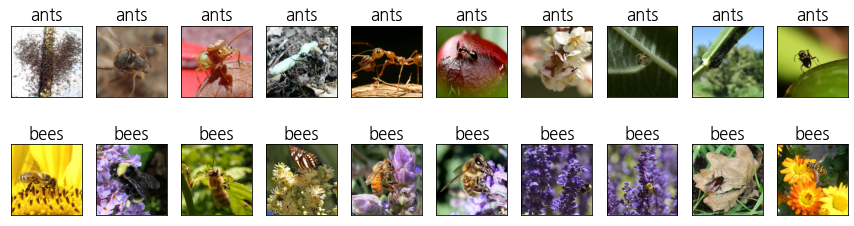

In [ ]:
# 검증 데이터　
# 처음 10개와 마지막 10개 이미지 출력

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### 데이터로더 정의

In [ ]:
# 데이터로더 정의

batch_size = 10

# 훈련용
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 검증용
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# 이미지 출력용
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

### 이미지 출력

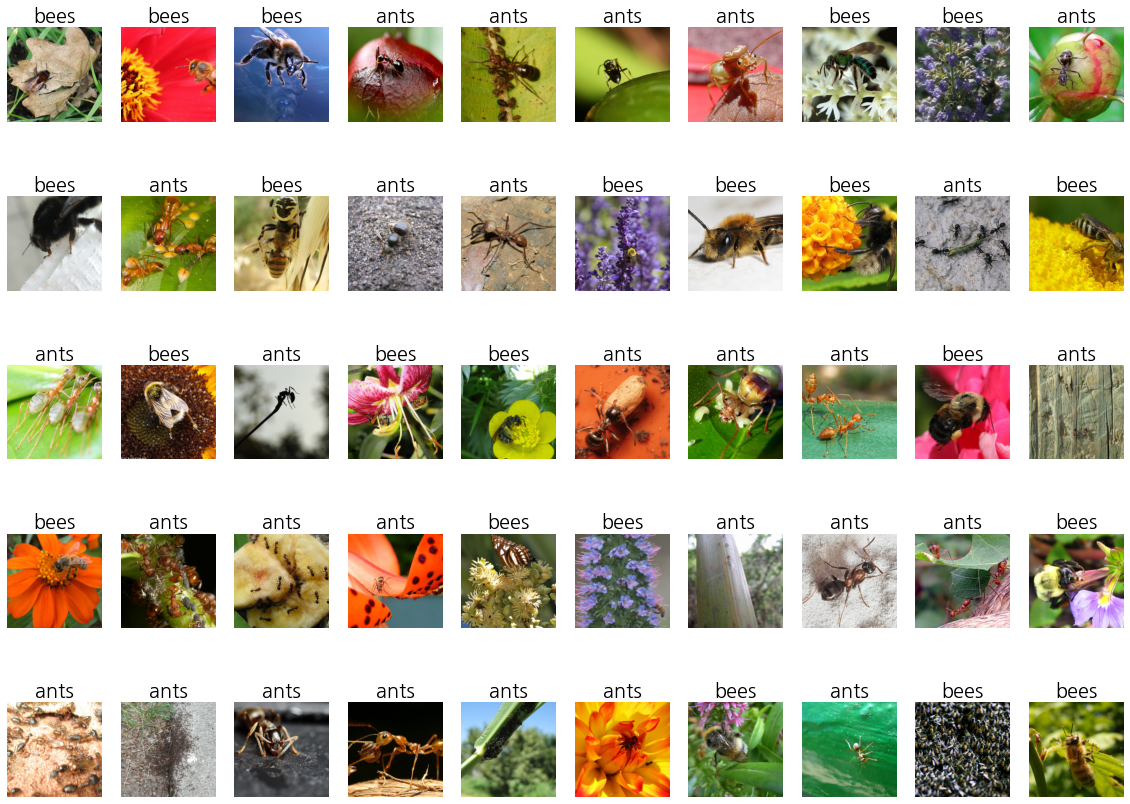

In [ ]:
# 검증 데이터(50건)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## 12.4 파인 튜닝의 경우

In [ ]:
# 파인 튜닝의 경우

# 사전 학습 모델 불러오기
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 난수 고정
torch_seed()

# 최종 노드의 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [ ]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04421 acc: 0.78689 val_loss: 0.01105, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.01980 acc: 0.92213 val_loss: 0.01319, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02082 acc: 0.91803 val_loss: 0.01025, val_acc: 0.97386


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.01423 acc: 0.93443 val_loss: 0.01558, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.01413 acc: 0.93443 val_loss: 0.01236, val_acc: 0.95425


초기상태 : 손실 : 0.01105  정확도 : 0.96078
최종상태 : 손실 : 0.01236 정확도 : 0.95425


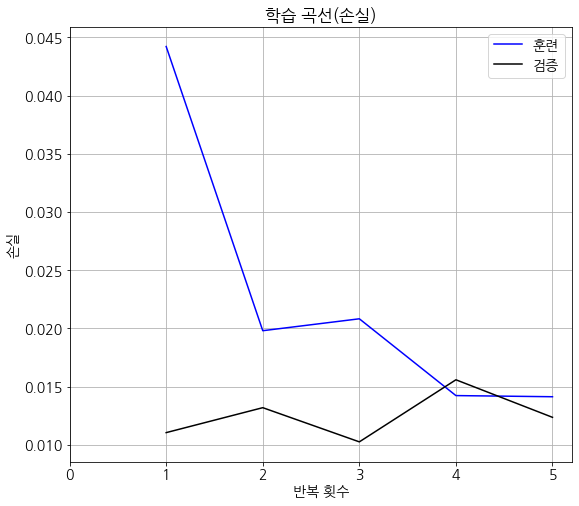

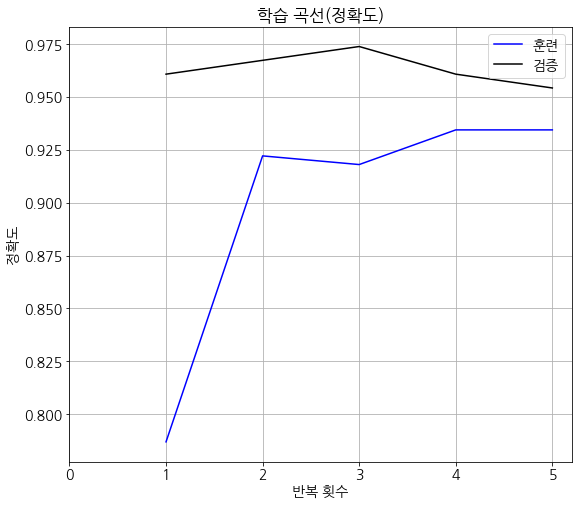

In [ ]:
# 결과 확인
evaluate_history(history)

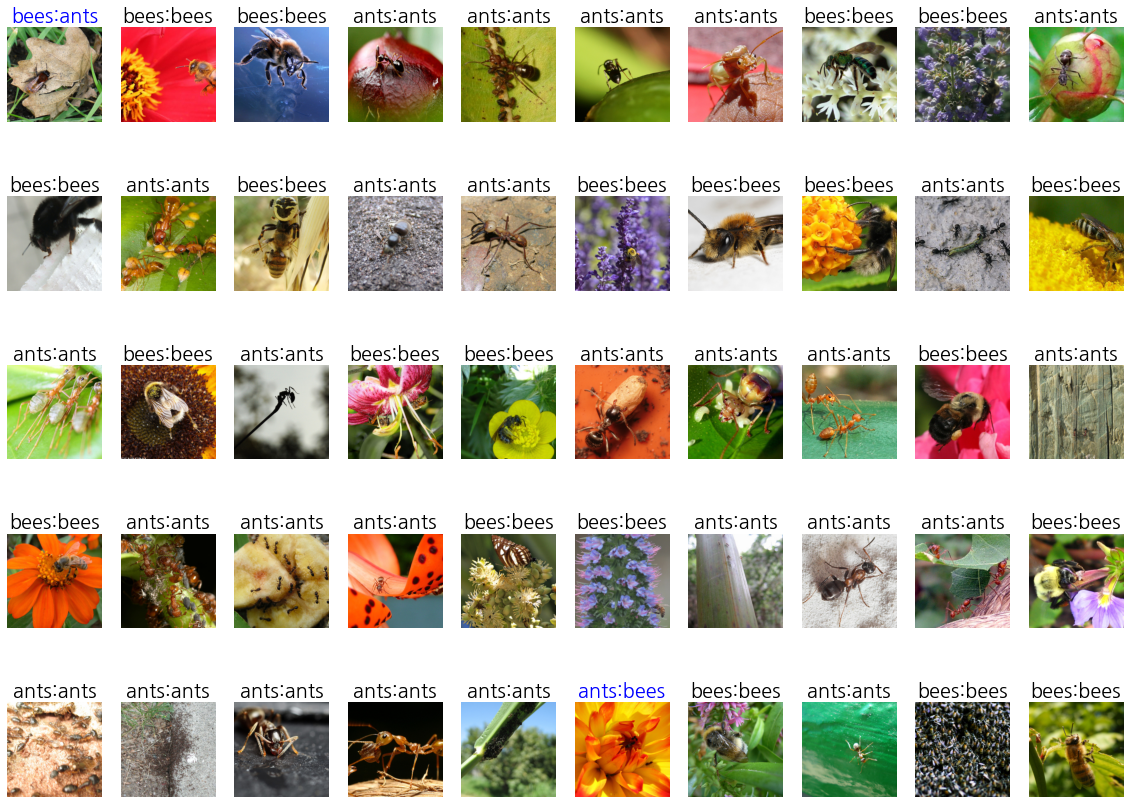

In [ ]:
# 난수 고정
torch_seed()

# 검증 데이터 결과 출력
show_images_labels(test_loader2, classes, net, device)


## 12.5 전이 학습의 경우

In [ ]:
# VGG-19-BN 모델을 학습이 끝난 파라미터와 함께 불러오기
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 모든 파라미터의 경사 계산을 OFF로 설정
for param in net.parameters():
    param.requires_grad = False

# 난수 고정
torch_seed()

# 최종 노드의 출력을 2로 변경
# 이 노드에 대해서만 경사 계산을 수행하게 됨
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수로 교차 엔트로피 사용
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [ ]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04625 acc: 0.78279 val_loss: 0.01375, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02263 acc: 0.92213 val_loss: 0.01272, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.02457 acc: 0.90164 val_loss: 0.01185, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02028 acc: 0.90164 val_loss: 0.01275, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.02133 acc: 0.88934 val_loss: 0.01191, val_acc: 0.96078


초기상태 : 손실 : 0.01375  정확도 : 0.96078
최종상태 : 손실 : 0.01191 정확도 : 0.96078


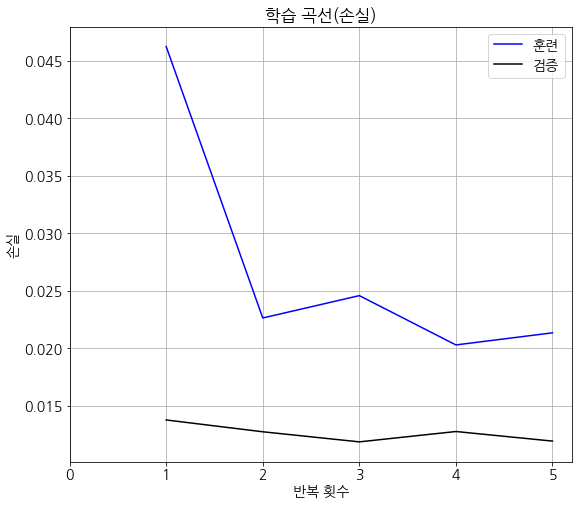

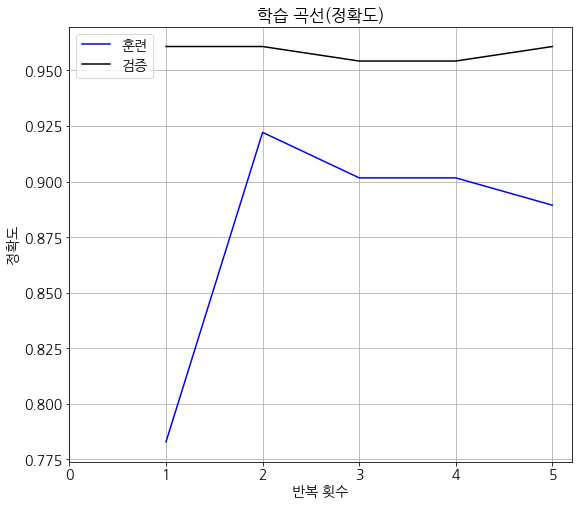

In [ ]:
# 결과 확인
evaluate_history(history)

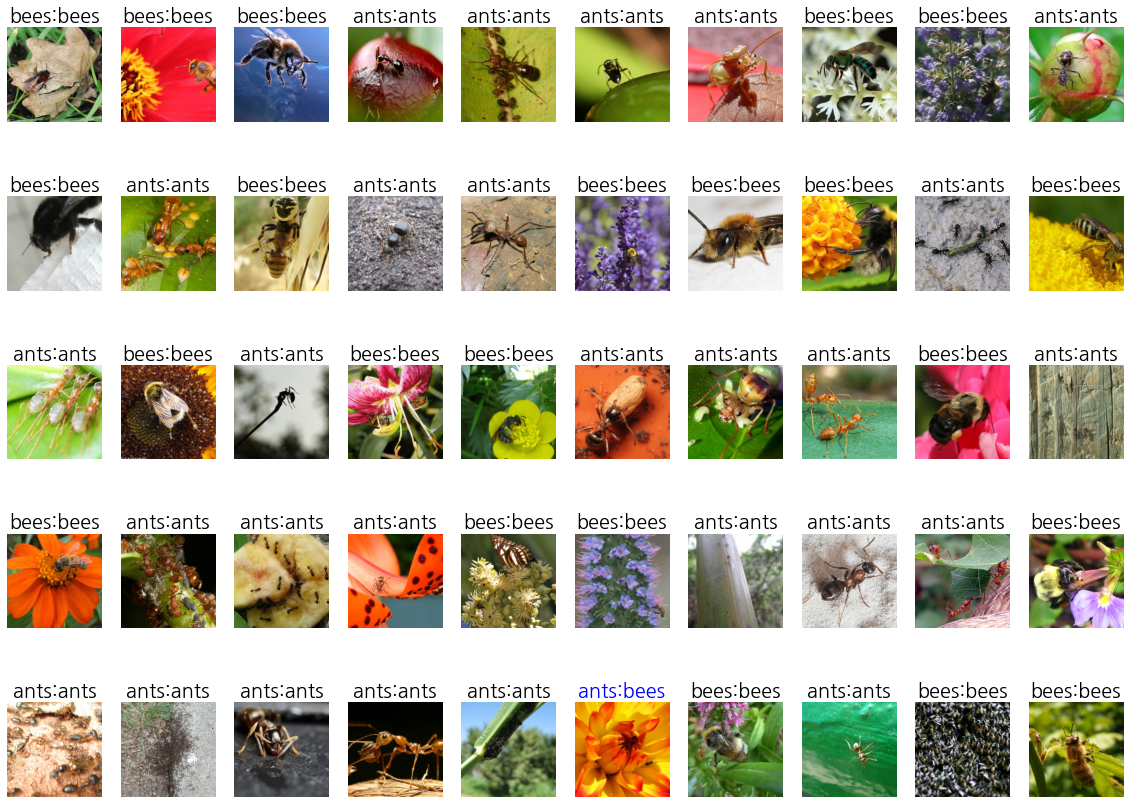

In [ ]:
# 난수 고정
torch_seed()

# 검증 데이터 결과 출력
show_images_labels(test_loader2, classes, net, device)

## 12.6 사용자 정의 데이터를 사용하는 경우
시베리안 허스키와 늑대 이미지를 사용함

### 데이터 다운로드, 압축 해제

In [ ]:
# 데이터 다운로드
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 압축 해제
!unzip dog_wolf.zip | tail -n 1

# 트리 구조 확인
!tree dog_wolf

2022-04-10 14:43:13 (142 MB/s) - ‘dog_wolf.zip’ saved [21811374/21811374]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├─

### Transforms 정의

In [ ]:
# Transforms 정의

# 검증 데이터 : 정규화
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 훈련 데이터 : 정규화에 반전과 RandomErasing 추가
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

### 데이터셋 정의

In [ ]:
# 데이터셋 정의

data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [ ]:
# 데이터 건수 확인

print(f'학습 데이터 : {len(train_data)} 건')
print(f'검증 데이터 : {len(test_data)} 건')

학습 데이터 : 40 건
검증 데이터 : 10 건


### 데이터로더 정의

In [ ]:
# 데이터로더 정의

batch_size = 5
# 훈련 데이터
train_loader = DataLoader(train_data, 
            batch_size=batch_size, shuffle=True)
# 훈련 데이터, 이미지 출력용
train_loader2 = DataLoader(train_data2, 
            batch_size=40, shuffle=False)
# 검증 데이터
test_loader = DataLoader(test_data, 
            batch_size=batch_size, shuffle=False)
# 검증데이터, 이미지 출력용
test_loader2 = DataLoader(test_data, 
            batch_size=10, shuffle=True)

### 이미지 출력

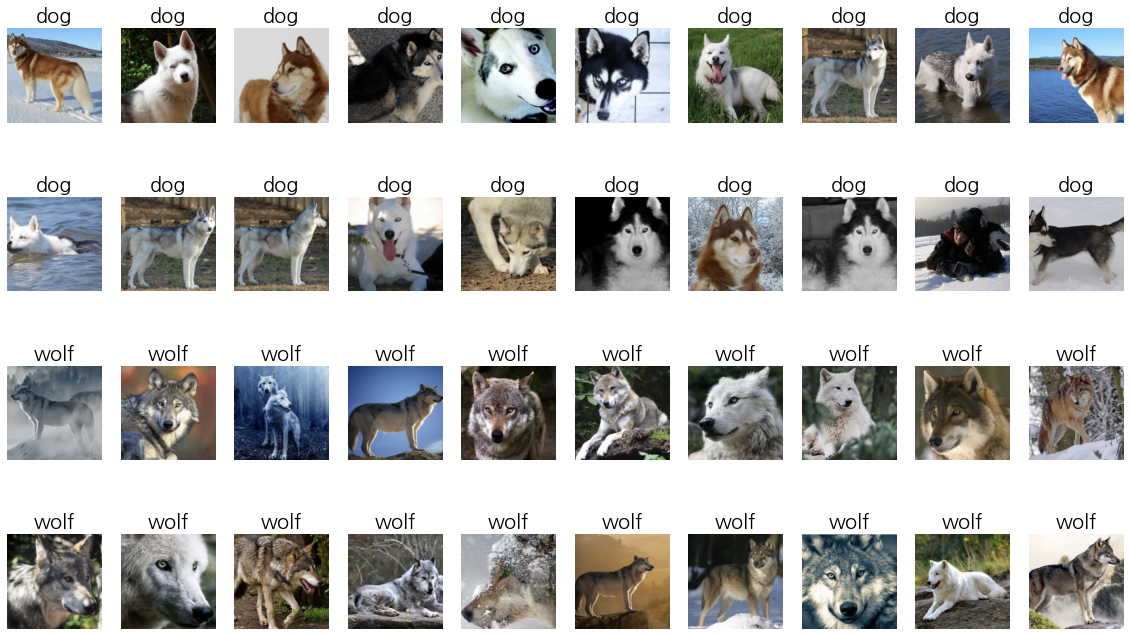

In [ ]:
# 훈련 데이터(40건)
show_images_labels(train_loader2, classes, None, None)

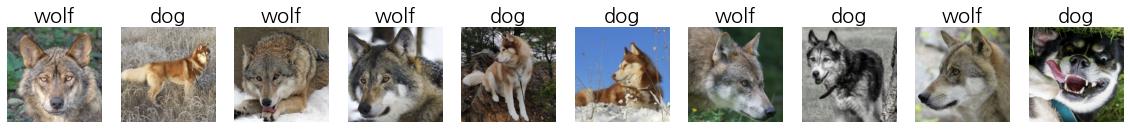

In [ ]:
# 검증 데이터(10건)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

### 모델 정의

In [ ]:
# 사전 학습 모델 불러오기
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 난수 고정
torch_seed()

# 마지막 노드 출력을 2로 변경
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d 함수 제거
net.avgpool = nn.Identity()

# GPU 사용
net = net.to(device)

# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# history 파일도 동시에 초기화
history = np.zeros((0, 5))

In [ ]:
# 학습
num_epochs = 10
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.12345 acc: 0.65000 val_loss: 0.07783, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.07584 acc: 0.85000 val_loss: 0.04895, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.03976 acc: 0.92500 val_loss: 0.05762, val_acc: 0.80000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.04213 acc: 0.92500 val_loss: 0.03992, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.01836 acc: 0.97500 val_loss: 0.02970, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.02144 acc: 0.97500 val_loss: 0.04182, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.03019 acc: 0.95000 val_loss: 0.03631, val_acc: 0.90000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.04319 acc: 0.92500 val_loss: 0.03186, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.01086 acc: 1.00000 val_loss: 0.02766, val_acc: 1.00000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.04419 acc: 0.92500 val_loss: 0.03189, val_acc: 1.00000


초기상태 : 손실 : 0.07783  정확도 : 1.00000
최종상태 : 손실 : 0.03189 정확도 : 1.00000


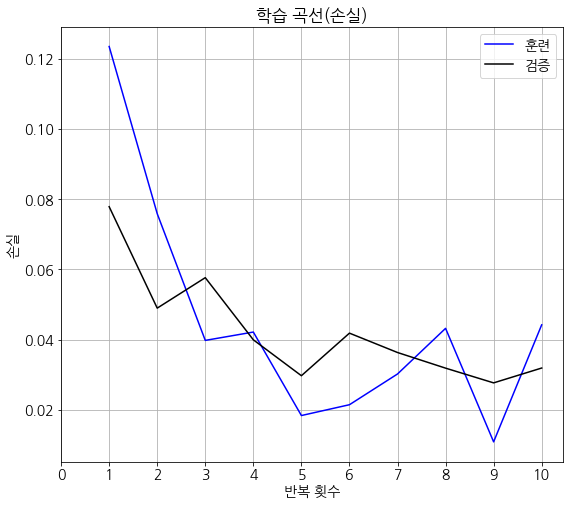

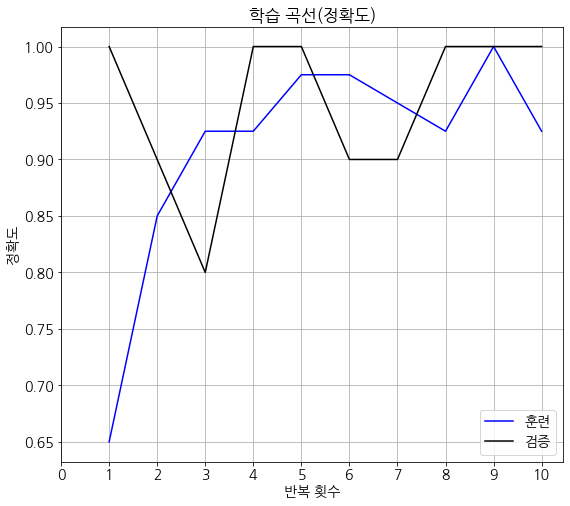

In [ ]:
# 결과 확인
evaluate_history(history)

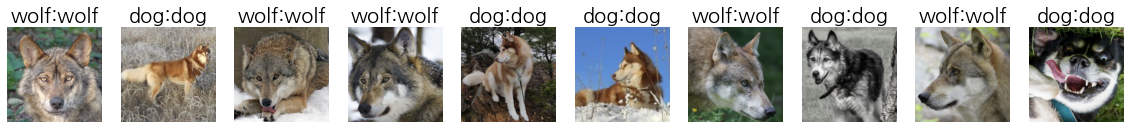

In [ ]:
# 예측 결과 출력
torch_seed()
show_images_labels(test_loader2, classes, net, device)